---
author: Harsha R. Hampapura
title: Precipitation plots from ERA5
---

## Access ERA5 data from NCAR's GDEX and plot mean total precipitation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import intake
import intake_esm
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

## Required Packages
Please make sure to installed the packages before moving forward
- matplotlib
- xarray
- dask
- cartopy
- zarr < 3

In [2]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)
#
era5_catalog_url ='https://osdf-director.osg-htc.org/ncar/gdex/d633000/catalogs/d633000-osdf.json'

/glade/derecho/scratch/harshah


In [4]:
USE_PBS_SCHEDULER = True

In [5]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = glade_scratch + '/dask/spill',
        log_directory = glade_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(5)
    return cluster

In [6]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34923 instead
  warnings.warn(


In [7]:
# Scale the cluster and display cluster dashboard URL
n_workers =5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(7fba61d9, 'tcp://128.117.208.116:46549', workers=5, threads=5, memory=20.00 GiB)

In [9]:
%%time
era5_cat = intake.open_esm_datastore(era5_catalog_url)
era5_cat

CPU times: user 125 ms, sys: 7.47 ms, total: 133 ms
Wall time: 5.66 s


,unique
path,172
variable,173
format,2
short_name,173
long_name,173
units,29
start_time,2
end_time,3
level,1
level_units,1


In [10]:
era5_cat.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/gdex/data/d633000/...,VAR_100U,zarr,100u,100 metre U wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,<NA>,<NA>,3600000000000 nanoseconds
1,/glade/campaign/collections/gdex/data/d633000/...,VAR_100V,zarr,100v,100 metre V wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,<NA>,<NA>,3600000000000 nanoseconds
2,/glade/campaign/collections/gdex/data/d633000/...,VAR_10U,zarr,10u,10 metre U wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,<NA>,<NA>,3600000000000 nanoseconds
3,/glade/campaign/collections/gdex/data/d633000/...,VAR_10V,zarr,10v,10 metre V wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,<NA>,<NA>,3600000000000 nanoseconds
4,/glade/campaign/collections/gdex/data/d633000/...,VAR_2D,zarr,2d,2 metre dewpoint temperature,K,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,<NA>,<NA>,3600000000000 nanoseconds
...,...,...,...,...,...,...,...,...,...,...,...
192,/glade/campaign/collections/gdex/data/d633000/...,VAR_10FG,reference,10fg,10 metre wind gust since previous post-processing,m s**-1,<NA>,<NA>,<NA>,<NA>,<NA>
193,/glade/campaign/collections/gdex/data/d633000/...,MX2T,reference,mx2t,Maximum temperature at 2 metres since previous...,K,<NA>,<NA>,<NA>,<NA>,<NA>
194,/glade/campaign/collections/gdex/data/d633000/...,MXTPR,reference,mxtpr,Maximum total precipitation rate since previou...,kg m**-2 s**-1,<NA>,<NA>,<NA>,<NA>,<NA>
195,/glade/campaign/collections/gdex/data/d633000/...,MN2T,reference,mn2t,Minimum temperature at 2 metres since previous...,K,<NA>,<NA>,<NA>,<NA>,<NA>


In [11]:
era5_cat.df[['variable','long_name']].drop_duplicates()

,variable,long_name
0,VAR_100U,100 metre U wind component
1,VAR_100V,100 metre V wind component
2,VAR_10U,10 metre U wind component
3,VAR_10V,10 metre V wind component
4,VAR_2D,2 metre dewpoint temperature
...,...,...
192,VAR_10FG,10 metre wind gust since previous post-processing
193,MX2T,Maximum temperature at 2 metres since previous...
194,MXTPR,Maximum total precipitation rate since previou...
195,MN2T,Minimum temperature at 2 metres since previous...


In [12]:
cat_subset = era5_cat.search(variable='MTPR')
cat_subset.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/gdex/data/d633000/...,MTPR,reference,mtpr,Mean total precipitation rate,kg m**-2 s**-1,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
##############################################################

In [ ]:
# Define the xarray_open_kwargs with a compatible engine, for example, 'scipy'
xarray_open_kwargs = {
    'engine': 'h5netcdf',
    'chunks': {},  # Specify any chunking if needed
    'backend_kwargs': {}  # Any additional backend arguments if required
}

In [13]:
%%time
# dset_temp = temp_cat.to_dataset_dict(xarray_open_kwargs=xarray_open_kwargs)
dset_subset = cat_subset.to_dataset_dict(xarray_open_kwargs={'engine':'zarr','backend_kwargs':{'consolidated': True,'zarr_format': 2}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


<div><progress max="1" value="1"></progress> 100.00% [1/1 00:10&lt;00:00]</div>

CPU times: user 532 ms, sys: 63.9 ms, total: 596 ms
Wall time: 10.3 s


In [14]:
dset_subset

{'MTPR.mtpr': <xarray.Dataset> Size: 3TB
 Dimensions:                (forecast_initial_time: 61666, forecast_hour: 12,
                             latitude: 721, longitude: 1440)
 Coordinates:
   * forecast_initial_time  (forecast_initial_time) datetime64[ns] 493kB 1940-...
   * forecast_hour          (forecast_hour) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
   * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
   * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
 Data variables:
     MTPR                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 3TB dask.array<chunksize=(2, 12, 721, 1440), meta=np.ndarray>
     utc_date               (forecast_initial_time) int32 247kB dask.array<chunksize=(61666,), meta=np.ndarray>
 Attributes: (12/17)
     CONVERSION_DATE:                 Wed Nov  2 10:03:48 MDT 2022
     CONVERSION_PLATFORM:             Linux r3i0n28 4.12.14-95.51-default #1 S...
     Conventions:        

In [15]:
mtpr = dset_subset['MTPR.mtpr']
mtpr

<xarray.Dataset> Size: 3TB
Dimensions:                (forecast_initial_time: 61666, forecast_hour: 12,
                            latitude: 721, longitude: 1440)
Coordinates:
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 493kB 1940-...
  * forecast_hour          (forecast_hour) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    MTPR                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 3TB dask.array<chunksize=(2, 12, 721, 1440), meta=np.ndarray>
    utc_date               (forecast_initial_time) int32 247kB dask.array<chunksize=(61666,), meta=np.ndarray>
Attributes: (12/17)
    CONVERSION_DATE:                 Wed Nov  2 10:03:48 MDT 2022
    CONVERSION_PLATFORM:             Linux r3i0n28 4.12.14-95.51-default #1 S...
    Conventions:                     CF-1.6
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    ...                              ...
    intake_esm_attrs:variable:       MTPR
    intake_esm_attrs:_data_format_:  reference
    intake_esm_attrs:short_name:     mtpr
    intake_esm_attrs:long_name:      Mean total precipitation rate
    intake_esm_attrs:units:          kg m**-2 s**-1
    intake_esm_dataset_key:          MTPR.mtpr

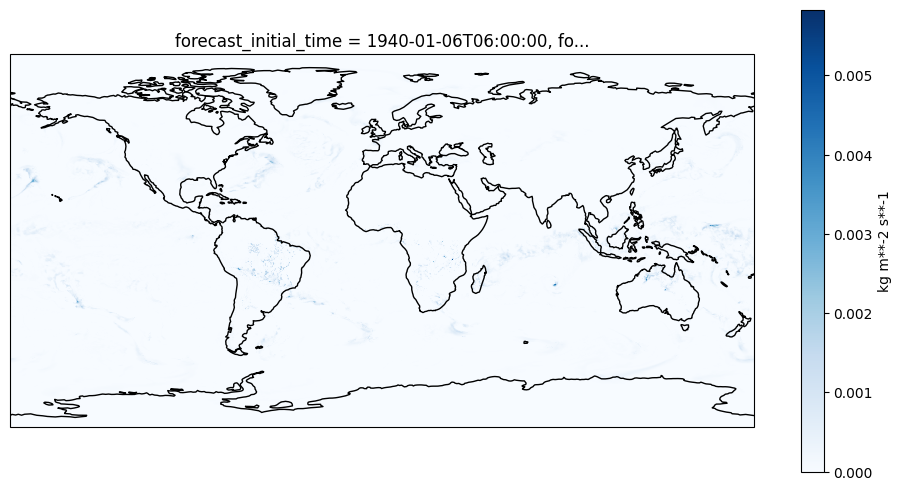

In [16]:
da = mtpr.MTPR.isel(forecast_hour=10).isel(forecast_initial_time=10)

# 2) Make a Cartopy map axis
proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})

# 3) Plot onto that axis
im = da.plot(
    ax=ax,  
    transform=ccrs.PlateCarree(),
    cmap = 'Blues',
    x="longitude",
    y="latitude",
    #robust=True,                
    cbar_kwargs={"label": getattr(da, "units", "")},
)

ax.coastlines(color="black", linewidth=1.0)

In [17]:
cluster.close()